# 흉부 X-ray 이미지로 정상/코로나/폐렴을 분류하는 Image Classification 

In [ ]:
# Overview
# Classification 소개와 적용사례, CNN를 사용하는 이유
# Covid chest x-ray 데이터셋 소개 및 탐색, 문제정의
# 데이터셋 구축과 연산을 위한 텐서변환 적용해보기
# 대표적인 classifier 소개와 아키텍처 불러오기
# 순전파, 역전파 설명과 손실함수 불러오기
# classifier 학습을 위한 코드작성해보기
# 검증을 위한 지표 소개 및 적용해보기
# 학습한 모델을 실제로 테스트해보기
# Summary

## 1. 라이브러리 불러오기

In [1]:
import os
import copy
import random

import cv2
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ipywidgets import interact

random_seed = 2022

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. 이미지 파일경로 불러오기

In [2]:
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]
    
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [3]:
data_dir = "../DATASET/Classification/train/"

normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

print(f"Normal:{len(normals_list)}, Covid:{len(covids_list)}, pneumonias:{len(pneumonias_list)}")

Normal:70, Covid:111, pneumonias:70


## 3. 이미지파일을 RGB 3차원 배열로 불러오기

In [4]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## 4. 이미지데이터 확인하기

In [5]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# ---

## 5. 학습데이터셋 클래스 구축

In [6]:
train_data_dir = "../DATASET/Classification/train/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

In [7]:
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, "Normal")
        covids = list_image_files(data_dir, "Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")
        
        self.files_path = normals + covids + pneumonias
        self.transform = transform
        
    def __len__(self):
        return len(self.files_path)
    
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
         
        target = class_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()
            
        return {"image":image, "target":target}

In [8]:
dset = Chest_dataset(train_data_dir)

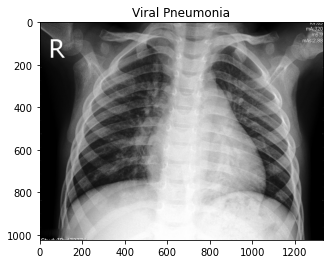

In [9]:
index = 200
plt.title(class_list[dset[index]["target"]])
plt.imshow(dset[index]["image"])

## 6. 배열을 연산가능한 텐서로 변환하기

In [10]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]) # RGB : 0.5, 0.5, .05
])

In [11]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [12]:
# without transformer

index = 200
image = dset[index]["image"]
label = dset[index]["target"]
print(image.shape, label)


(1024, 1336, 3) 2


In [13]:
# with transformer

index = 200
image = train_dset[index]["image"]
label = train_dset[index]["target"]
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([2])


## 7. 데이터로더 구현하기

In [14]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders["train"] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders["val"] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [15]:
train_data_dir = "../DATASET/Classification/train/"
val_data_dir = "../DATASET/Classification/test/"
dataloaders = build_dataloader(train_data_dir, val_data_dir)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x20e480ca760>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x20e480f5160>}

In [16]:
for i, d in enumerate(dataloaders["train"]):
    if i == 0:
        break

In [17]:
d["target"].shape

torch.Size([4, 1])

In [18]:
d["target"].squeeze()

tensor([1, 2, 2, 1])

# ---

## 8. Classification 모델(VGG19) 불러오기

In [29]:
model = models.vgg19(pretrained=True)

In [33]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

## 9. 데이터에 맞도록 모델 Head 부분 변경하기

In [34]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # (1,1)로 데이터 pooling 실행
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(256, len(class_list)),
    nn.Softmax(),
)

In [35]:
def build_vgg19_based_model(device_name='cuda'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [36]:
model = build_vgg19_based_model(device_name='cuda')

In [37]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# ---

## 10. 손실함수 불러오기

In [38]:
# reduction: mini batch 개수에 대한 평균을 구해서 return

loss_func = nn.CrossEntropyLoss(reduction="mean")

## 11. Gradient 최적화 함수 불러오기

In [39]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3, momentum=0.9)

# ---

## 12. 모델 검증을 위한 Accuracy 생성하기

In [47]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)  # (B, NUM_CLASSES) -> [B,0]: 0.1, [B,1]: 0.1, [B,2]: 0.7
    _, pred_label = torch.max(prediction, dim=1)  # [B,1] -> pred_label: 1
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

# ---

## 13. 모델 학습을 위한 함수 구현하기

In [48]:
device = torch.device("cuda")

In [49]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    for phase in ["train", "val"]:
        
        running_loss = 0.0
        running_correct = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            image = batch["image"].to(device)
            target = batch["target"].squeeze(1).to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders[phase])} - Running Loss: {loss.item()}")

        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

In [50]:
def save_best_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

## 14. 모델 학습 수행하기

In [51]:
device = torch.device("cuda")

train_data_dir = "../DATASET/Classification/train/"
val_data_dir = "../DATASET/Classification/test/"

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name='cuda')
loss_func = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3, momentum=0.9)

In [52]:
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")
    
    if (epoch > 3) and (accuracies["val"] > best_acc):
        best_acc = accuracies["val"]
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f"model_{epoch+1:02d}.pth")
        
print(f"Best Accuracy: {best_acc}")

0/62 - Running Loss: 1.1159489154815674
10/62 - Running Loss: 1.1047616004943848
20/62 - Running Loss: 1.0900708436965942
30/62 - Running Loss: 1.0918688774108887
40/62 - Running Loss: 1.0529496669769287
50/62 - Running Loss: 1.0030574798583984
60/62 - Running Loss: 1.185700535774231
1/10-Train Loss: 1.0769562365547303, Val Loss: 1.0262889789812493
1/10-Train Acc: 0.4314516129032258, Val Acc: 0.45454545454545453
0/62 - Running Loss: 0.9641876816749573
10/62 - Running Loss: 0.9104188084602356
20/62 - Running Loss: 0.9597246050834656
30/62 - Running Loss: 1.072425365447998
40/62 - Running Loss: 0.6692644357681274
50/62 - Running Loss: 0.845720648765564
60/62 - Running Loss: 0.8204576969146729
2/10-Train Loss: 0.8803254885058249, Val Loss: 0.8644496310840953
2/10-Train Acc: 0.6935483870967742, Val Acc: 0.696969696969697
0/62 - Running Loss: 0.9303432106971741
10/62 - Running Loss: 0.834624171257019
20/62 - Running Loss: 0.8191774487495422
30/62 - Running Loss: 0.7310751676559448
40/62 - R

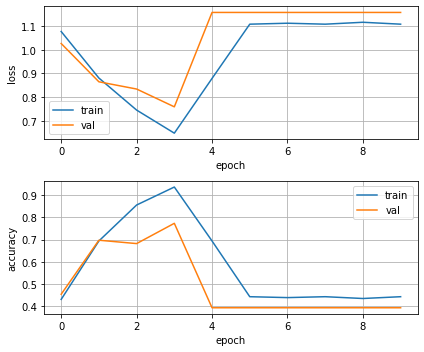

In [53]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

# ---

## 15. 테스트 이미지를 통한 학습모델 분류성능검증하기

In [54]:
data_data = "../DATASET/Classification/test/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

test_normals_list = list_image_files(data_dir, "Normal")
test_covids_list = list_image_files(data_dir, "Covid")
test_pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [55]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 244)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ])
    
    tensor_image = transformer(image)  # (C, H, W)
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W)
    return tensor_image

In [56]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _, pred_label = torch.max(prediction.detach(), dim=1)
    pred_label = pred_label.squeeze(0) # dummy batch 삭제 (B, 1) -> (1)
    return pred_label.item()

In [67]:
ckpt = torch.load("./trained_model/model_06.pth")

model = build_vgg19_based_model(device_name='cpu')
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [68]:
model.load_state_dict(ckpt)

<All keys matched successfully>

In [69]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[prediction_1]} | GT:Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title(f"Pred:{class_list[prediction_2]} | GT:Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title(f"Pred:{class_list[prediction_3]} | GT:Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…